## Кошки и собаки

Обучим модель различать кошек и собак различной породы. Для этого будем использовать tensorflow / Keras. Импортируем библиотеки:

In [1]:
import os
# Отключаем лишние сообщения от Tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow import keras 

print(f"Версия Tensorflow: {tf.__version__}")

Версия Tensorflow: 2.12.0


Видим, что все основные библиотеки уже установлены в DataSphere "из коробки".

На первом этапе обучение будем использовать датасет [Oxford III Pets](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet), доступный через библиотеку Tensorflow Datasets. Сразу разобьем его на обучающую и тестовую выборку, причём возмём побольше изображений в обучающую.

> Ниже мы используем хитрый код с `gcs_utils`, чтобы избежать загрузки датасета с Google Cloud, а загружать его напрямую из первоисточника.

In [2]:
# Фрагмент кода ниже позволяет загрузить датасет напрямую из первоисточника,
# что ускоряет загрузку в среде Datasphere
from tensorflow_datasets.core.utils import gcs_utils
gcs_utils.gcs_dataset_info_files = lambda *args, **kwargs: None
gcs_utils.is_dataset_on_gcs = lambda *args, **kwargs: False
tfds.disable_progress_bar()

(train_raw, val_raw), ds_info = tfds.load(name='oxford_iiit_pet',
                                    split=['train+test[:50%]', 'test[50%:]'],
                                    shuffle_files=True,
                                    as_supervised=True, # получаем пары (image, label)
                                    with_info=True # получает также метаданные
)

Посмотрим, как выглядят изображения в датасете:

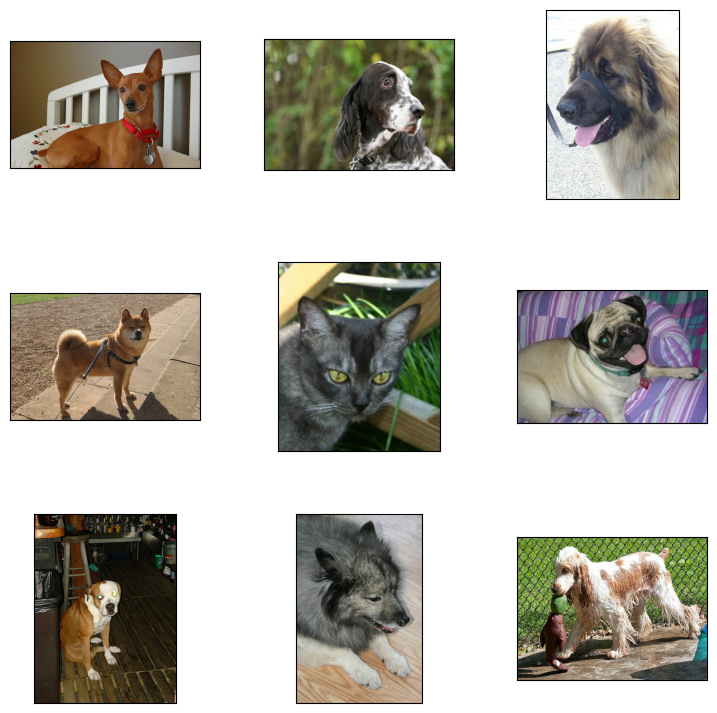

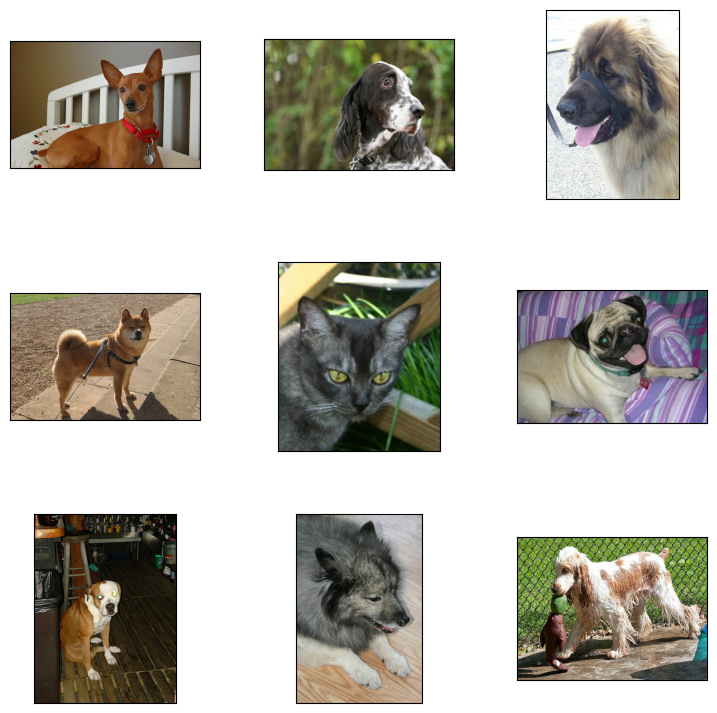

In [3]:
tfds.show_examples(train_raw, ds_info, image_key='image')

Также посмотрим на размеры обучающего и тестового датасетов:

In [4]:
len(train_raw), len(val_raw)

(5514, 1835)

Поскольку для обучения мы будем использовать Transfer Learning и предобученную на ImageNet сеть, то нам нужно привести все изображения к размеру 224x224: 

In [6]:
IMG_SIZE = 224

train_ds = train_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))
val_ds = val_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))

Загрузим базовую модель - будем использовать ResNet50. Эту модель мы заморозим и будем использовать лишь как feature extractor.

In [7]:
base_model = keras.applications.ResNet50V2(
                            include_top=False, # Exclude ImageNet classifier at the top.
                            weights="imagenet",
                            input_shape=(IMG_SIZE, IMG_SIZE, 3)
                            )
base_model.trainable = False


Получим из метаданных количество классов, и опишем нашу модель классификации:
* В качестве первого слоя используем функцию предобработки изображений `preprocess_input`, чтобы не вызывать её отдельно для всего датасета, а делать это внутри самой модели
* После применения базовой модели используем `Flatten` для превращения объемного тензора в вектор
* На последней слое используем функцию активации `softmax` для нормализации вектора вероятностей

In [9]:
num_classes = ds_info.features['label'].num_classes

model = keras.Sequential([
    keras.layers.Lambda(lambda x : keras.applications.resnet_v2.preprocess_input(x)),
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dense(num_classes,activation='softmax')])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

Разобъем датасет на минибатчи по 32 изображения и будем обучать модель в течение заданного количества эпох:

In [10]:
BATCH_SIZE=32
EPOCHS = 10

train_ds_b = train_ds.batch(batch_size=BATCH_SIZE, 
                          drop_remainder=True).prefetch(tf.data.AUTOTUNE)
val_ds_b = val_ds.batch(batch_size=BATCH_SIZE, 
                      drop_remainder=True).prefetch(tf.data.AUTOTUNE)

history = model.fit(train_ds_b, epochs=EPOCHS, validation_data=val_ds_b)

Epoch 1/5
 16/172 [=>............................] - ETA: 5s - loss: 13.3585 - acc: 0.4004

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 25/172 [===>..........................] - ETA: 7s - loss: 11.1906 - acc: 0.4925

Corrupt JPEG data: premature end of data segment


172/172 [==============================] - 54s 266ms/step - loss: 6.5783 - acc: 0.7355 - val_loss: 6.6621 - val_acc: 0.7911
Epoch 2/5
 23/172 [===>..........................] - ETA: 5s - loss: 1.6063 - acc: 0.9334

Corrupt JPEG data: premature end of data segment


 25/172 [===>..........................] - ETA: 5s - loss: 1.6652 - acc: 0.9300

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


172/172 [==============================] - 8s 46ms/step - loss: 1.8427 - acc: 0.9242 - val_loss: 6.5836 - val_acc: 0.8268
Epoch 3/5
 24/172 [===>..........................] - ETA: 5s - loss: 0.8733 - acc: 0.9635

Corrupt JPEG data: premature end of data segment


 26/172 [===>..........................] - ETA: 5s - loss: 0.8619 - acc: 0.9627

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


172/172 [==============================] - 8s 46ms/step - loss: 0.8156 - acc: 0.9602 - val_loss: 6.2248 - val_acc: 0.8498
Epoch 4/5
 23/172 [===>..........................] - ETA: 5s - loss: 0.2725 - acc: 0.9864

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 25/172 [===>..........................] - ETA: 5s - loss: 0.2507 - acc: 0.9875

Corrupt JPEG data: premature end of data segment


172/172 [==============================] - 8s 46ms/step - loss: 0.4244 - acc: 0.9787 - val_loss: 6.7395 - val_acc: 0.8465
Epoch 5/5
 23/172 [===>..........................] - ETA: 5s - loss: 0.3323 - acc: 0.9851

Corrupt JPEG data: premature end of data segment


 25/172 [===>..........................] - ETA: 5s - loss: 0.3057 - acc: 0.9862

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


172/172 [==============================] - 8s 46ms/step - loss: 0.3220 - acc: 0.9844 - val_loss: 7.2065 - val_acc: 0.8427


Построим график изменения точности на обучающей и валидационной выборках в процессе обучения:

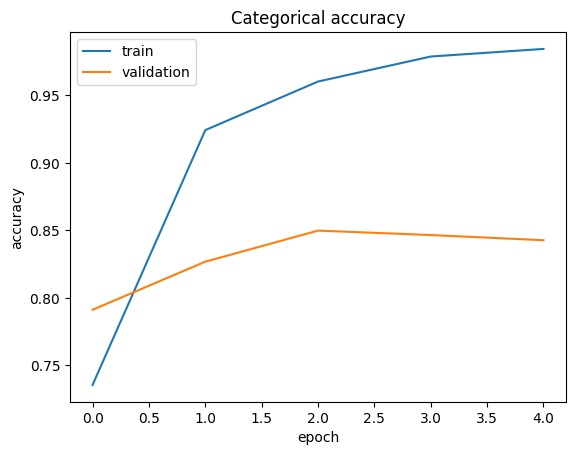

In [12]:
def plot_hist(hist):
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('Categorical accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(history)

Для того, чтобы посмотреть на точность обучения, и какие классы модель "путает", построим матрицу ошибок.

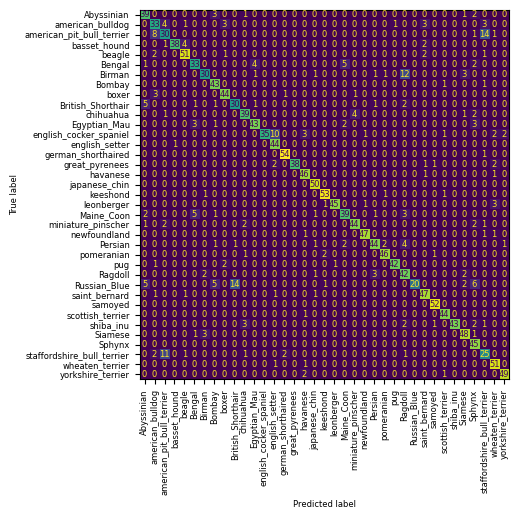

In [19]:
import numpy as np 
from sklearn.metrics import ConfusionMatrixDisplay
labels = [ ds_info.features['label'].int2str(i) for i in range(num_classes)]
x,y_true = zip(*val_ds)
y_true = [x.numpy() for x in y_true]
y_pred = model(np.array(x))
y_pred = tf.argmax(y_pred,axis=1).numpy()

plt.rc('font',size=6)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,
                                        display_labels=labels,
                                        xticks_rotation='vertical',
                                        colorbar=False)

Мы добились неплохой точности модели, хотя из матрицы видно, что модель пока ещё путает некоторые породы терьеров. Для улучшения качества модели можно:
* Использовать аугментацию данных в процессе обучения 
* Попробовать различные базовые модели и другие гиперпараметры (число слоёв полносвязного классификатора и т.д.)
